# Tutorial CV1 - Photon redirection

This tutorial runs PennyLane's "hello world" example of continuous-variable quantum computation with the StrawberryFields plugin. Starting with a photon in Mode 1, the goal is to optimize a beam splitter to redirect the photon to Mode 2. 

We compare the gradient descent optimizer without and with momentum for this task.

### Imports

First we need to import openqml, as well as openqml's version of numpy. This allows us to automatically compute gradients for functions that manipulate numpy arrays, including quantum functions.

In [1]:
import openqml as qm
import numpy as np
from openqml.optimize import GradientDescentOptimizer, MomentumOptimizer

Next, create a "device" to run the quantum node. We use StrawberryFields to simulate a photonic quantum processor with two quantum modes.

In [2]:
dev = qm.device('strawberryfields.fock', wires=2, cutoff_dim=10)

### Quantum node

We define a quantum circuit which starts with one photon into the first mode and sends both modes through a beam splitter. 
 
*Note: The `qm.qnode(dev)` decorator does the same as importing the `QNode` class via `from openqml.qnode import QNode` and creating a qnode `circuit = QNode(circuit, dev)`.*

In [3]:
@qm.qnode(dev)
def circuit(vars):

    qm.FockState(1, [0])
    qm.Beamsplitter(vars[0], vars[1], [0, 1])

    return qm.expval.PhotonNumber(0)

This function uses openqml to run the following quantum circuit:

<img src="figures/redirection_circuit.png">

Depending on the variable $v_1$, the transmission parameter of the beam splitter, the photon remains in the first mode (for $v_1 = n \pi$ with integer $n$), gets redirected to the second mode (for $v_2 = n\pi / 2$) or is in a superposition of being in both modes. The phase parameter $v_2$ does not have any influence on the result, so we expect it to have a zero gradient and not to get updated at all.

### Objective

Next, we define a cost that quantifies whether the redirection is successful. Since we want to maximize the expectation of the photon number in the second mode, we can minize expectation of the photon number in the first mode. (Alternatively, we could also minimize the negative of the photon number in the second mode.)

In [4]:
def objective(vars):
    return circuit(vars)

This objective has the following optimization landscape. *Note: To run the following cell you need the matplotlib library.*

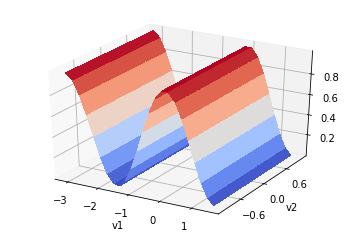

In [6]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import MaxNLocator

fig = plt.figure(figsize = (6, 4))
ax = fig.gca(projection='3d')

X = np.arange(-3.1, 1.6, 0.2)
Y = np.arange(-1., 1.25, 0.25)

xx, yy = np.meshgrid(X, Y)
Z = np.array([[objective([x, y]) for x in X] for y in Y]).reshape(len(Y), len(X))
surf = ax.plot_surface(xx, yy, Z, cmap=cm.coolwarm, antialiased=False)

ax.set_xlabel("v1")
ax.set_ylabel("v2")
ax.zaxis.set_major_locator(MaxNLocator(nbins = 5, prune = 'lower'))
ax.yaxis.set_major_locator(MaxNLocator(nbins = 4, prune = 'lower'))

plt.show()

As stated above, the gradient does not depend on the phase parameter $v_2$. 

### Optimization

We choose a simple Gradient Descent Optimizer with a step size of 0.1.

In [7]:
gd = GradientDescentOptimizer(stepsize=0.1)

The initial values of the variabels are set to near-zero. This corresponds to an identity gate, in other words, the circuit leaves the photon in the first mode. *Note that at zero exactly the gradient vanishes and the optimization algorithm will not descent from the maximum.*

In [8]:
vars_init = np.array([0.01, -0.5])

We optimize the weights for 100 steps.

In [9]:
vars = vars_init
vars_gd = []

for iteration in range(100):
    vars = gd.step(objective, vars)
    vars_gd.append(vars)
    
    if iteration % 10 == 0:
        print('Cost after step {:3d}: {:0.7f} | Variables [{:0.7f}, {:0.7f}]'
              ''.format(iteration, objective(vars), vars[0], vars[1]))

Cost after step   0: 0.9998560 | Variables [0.0119999, -0.5000000]
Cost after step  10: 0.9945046 | Variables [0.0741993, -0.5000000]
Cost after step  20: 0.8206168 | Variables [0.4373458, -0.5000000]
Cost after step  30: 0.0723227 | Variables [1.2985156, -0.5000000]
Cost after step  40: 0.0009153 | Variables [1.5405375, -0.5000000]
Cost after step  50: 0.0000106 | Variables [1.5675459, -0.5000000]
Cost after step  60: 0.0000001 | Variables [1.5704473, -0.5000000]
Cost after step  70: 0.0000000 | Variables [1.5707589, -0.5000000]
Cost after step  80: 0.0000000 | Variables [1.5707923, -0.5000000]
Cost after step  90: 0.0000000 | Variables [1.5707959, -0.5000000]


Starting at a different offset, we train the MomentumOptimizer, which improves on gradient descent by making an update dependent on the previous gradient.

In [10]:
mm = MomentumOptimizer(stepsize=0.1, momentum=0.5)

vars_init = np.array([0.01, 0.5])

vars = vars_init
vars_mm = []

for iteration in range(100):
    vars = mm.step(objective, vars)
    vars_mm.append(vars)

    if iteration % 10 == 0:
        print('Cost after step {:3d}: {:0.7f} | Variables [{:0.7f}, {:0.7f}]'
              ''.format(iteration, objective(vars), vars[0], vars[1]))

Cost after step   0: 0.9998560 | Variables [0.0119999, 0.5000000]
Cost after step  10: 0.9657205 | Variables [0.1862217, 0.5000000]
Cost after step  20: 0.0055535 | Variables [1.4962052, 0.5000000]
Cost after step  30: 0.0000064 | Variables [1.5682634, 0.5000000]
Cost after step  40: 0.0000000 | Variables [1.5709673, 0.5000000]
Cost after step  50: 0.0000000 | Variables [1.5707922, 0.5000000]
Cost after step  60: 0.0000000 | Variables [1.5707963, 0.5000000]
Cost after step  70: 0.0000000 | Variables [1.5707963, 0.5000000]
Cost after step  80: 0.0000000 | Variables [1.5707963, 0.5000000]
Cost after step  90: 0.0000000 | Variables [1.5707963, 0.5000000]


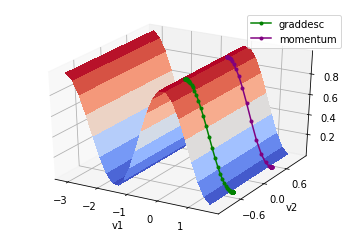

In [11]:
fig = plt.figure(figsize = (6, 4))
ax = fig.gca(projection='3d')

X = np.arange(-3.1, 1.6, 0.2)
Y = np.arange(-1., 1.25, 0.25)

xx, yy = np.meshgrid(X, Y)
Z = np.array([[objective([x, y]) for x in X] for y in Y]).reshape(len(Y), len(X))
surf = ax.plot_surface(xx, yy, Z, cmap=cm.coolwarm, antialiased=False)

path_z = [objective(vars)+1e-8 for vars in vars_gd]
path_x = [vars[0] for vars in vars_gd]
path_y = [vars[1] for vars in vars_gd]
ax.plot(path_x, path_y, path_z, c='green', marker='.', label="graddesc")

path_z = [objective(vars)+1e-8 for vars in vars_mm]
path_x = [vars[0] for vars in vars_mm]
path_y = [vars[1] for vars in vars_mm]
ax.plot(path_x, path_y, path_z, c='purple', marker='.', label="momentum")

ax.set_xlabel("v1")
ax.set_ylabel("v2")
ax.zaxis.set_major_locator(MaxNLocator(nbins = 5, prune = 'lower'))
ax.yaxis.set_major_locator(MaxNLocator(nbins = 4, prune = 'lower'))

plt.legend()
plt.show()